In [1]:

import tensorflow.keras as kr
import nibabel as nib
import numpy as np
import os
from glob import glob
import matplotlib.pylab as plt

folder_path = [os.path.join(r"/mnt/d/Fabio/deeplearningdata/archive_1/BraTS2021_Training_Data", i) for i in os.listdir(r"/mnt/d/Fabio/deeplearningdata/archive_1/BraTS2021_Training_Data")]
imgs = []


for i in folder_path:
    imgs.append(glob(i+"/*"))
print("Done")
folder_path = folder_path[1:]
imgs = imgs[1:]
print(imgs[0])



#input directory and output directory
outputpath = []
inputpath = []
for j in imgs:
    for i in j:
        if "seg.nii.gz" in i.split("_"):
            outputpath.append(i)
for j in imgs:
    temppath = []
    for i in j:
        if "seg.nii.gz" not in i.split("_"):
            temppath.append(i)
    inputpath.append(temppath)
    
x_train_path = inputpath[:1126].copy()
y_train_path = outputpath[:1126].copy()
x_eval_path = inputpath[1126:1189].copy()
y_eval_path = outputpath[1126:1189].copy()
x_test_path = inputpath[1189:].copy()
y_test_path = outputpath[1189:].copy()  

parition = {"train": x_train_path, "validation": x_eval_path}
label = {"train": y_train_path, "validation": y_eval_path}
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------OLD-------------------------------------------------------------------------------
# def prepoutput():
#     index = 0
#     outputimg = np.array((nib.load(outputpath[0]).get_fdata().astype(np.float32)[:, :, 75]))
#     outputimg = np.expand_dims(outputimg, axis=2)
#     outputimg = tf.image.resize(outputimg, (256, 256))
#     for i in range(1,len(outputpath)):
#         index+=1
#         print(index)
#         x = nib.load(outputpath[i]).get_fdata().astype(np.float32)[:, :, 75]
#         x = np.expand_dims(x, axis=2)
#         x = tf.image.resize(x, (256, 256))
#         outputimg = np.dstack((outputimg,x),)
#     return outputimg
# outputimg = prepoutput()
# outputimg = outputimg.transpose((2, 0, 1))
# np.save('output_dataset.npy', outputimg)

#


# inputimg = nib.load(inputpath[0][0]).get_fdata().astype(np.float32)[:, :, 75]
# for i in range(1,len(inputpath[0])):
#     inputimg = np.dstack((inputimg,nib.load(inputpath[0][i]).get_fdata().astype(np.float32)[:, :, 75]))
# inputimg = np.expand_dims(inputimg, axis=0)

# for i in range(1,len(inputpath)):
#     print(i)
    
#     temp = nib.load(inputpath[i][0]).get_fdata().astype(np.float32)[:, :, 75]
#     print("\t1")
#     print(f"\t{inputpath[i][0]}")
#     for channels in range(1,len(inputpath[i])):
#         print(f"\t{channels+1}")
#         print(f"\t{inputpath[i][channels]}")
#         temp = np.dstack((temp,nib.load(inputpath[i][channels]).get_fdata().astype(np.float32)[:, :, 75]))
        
#     temp = np.expand_dims(temp, axis=0)
#     inputimg = np.concatenate((inputimg,temp), axis=0)
#     print(inputimg.shape)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------------------------

import numpy as np
import keras
import random
import time
import os
import nibabel as nib

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(240,240,140), n_channels=4,
                 n_classes=10, shuffle=True, real_batchsize_custom=2, frames_chunk=18,
                 y_VolSlice_start=0, y_VolSlice_end=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.real_batchsize_custom = real_batchsize_custom
        self.frames_chunk = frames_chunk
        self.y_VolSlice_start = y_VolSlice_start
        self.y_VolSlice_end = y_VolSlice_end if y_VolSlice_end is not None else dim[2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        sliced_dim = (self.dim[0], self.dim[1], self.y_VolSlice_end - self.y_VolSlice_start)
        X = np.empty((self.real_batchsize_custom, *sliced_dim, 4))
        y = np.empty((self.real_batchsize_custom,*sliced_dim, 4), dtype=float)

        initial_point = 0
        final_point = self.frames_chunk
        for x in range(self.real_batchsize_custom):    
            indexes_orig = indexes[initial_point:final_point]
            list_IDs_temp = [self.list_IDs[k] for k in indexes_orig]
            X_in, y_in = self.__data_generation(list_IDs_temp)
            X[x] = X_in
            y[x] = y_in
            initial_point = final_point
            final_point = final_point + self.frames_chunk   
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        sliced_dim = (self.dim[0], self.dim[1], self.y_VolSlice_end - self.y_VolSlice_start)
        X = np.empty((1, *sliced_dim, 4))
        y = np.zeros((1,*sliced_dim,4))
        
        random.seed(time.time())

        for i, file_paths in enumerate(list_IDs_temp):
            image = self.load_nifti(file_paths)
                

            X[0] = image
            
            
            # Set the label
            seg = nib.load(self.labels[i]).get_fdata().astype(np.float16)[:,:,self.y_VolSlice_start:self.y_VolSlice_end]
            seg[seg==4] = 3

            re= np.expand_dims(seg, axis=0)

            re = tf.image.resize(re,(156,156))
            re = re[0]
            seg = tf.cast(re, tf.int32)
            print(seg.shape)
            mask = tf.one_hot(seg, 4);
            
            
            y[0] = mask
            
        X = X.astype(np.float16)
        y = y.astype(np.float16)
        
        return X[0], y[0]

    def load_nifti(self, file_paths):
        i = 0
        temp = nib.load(inputpath[i][0]).get_fdata().astype(np.float16)[:,:,self.y_VolSlice_start:self.y_VolSlice_end]
        re= np.expand_dims(temp, axis=0)
        re = tf.image.resize(re,(156,156))
        temp = re[0]
        
        temp = np.expand_dims(temp, axis=3)
        for channels in range(1,len(file_paths)):
            tempo = nib.load(file_paths[channels]).get_fdata().astype(np.float16)[:,:,self.y_VolSlice_start:self.y_VolSlice_end]
            re= np.expand_dims(tempo, axis=0)
            re = tf.image.resize(re,(156,156))
            tempo = re[0]
            tempo = np.expand_dims(tempo, axis=3)
            temp = np.concatenate((temp,tempo),axis=3)
        
        return temp
    
VolSlice_start = 10
VolSlice_end = 150


%store inputpath
%store outputpath
%store VolSlice_start
%store VolSlice_end




2024-06-30 21:08:02.983442: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 21:08:03.020193: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 21:08:03.557513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Done
['/mnt/d/Fabio/deeplearningdata/archive_1/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_flair.nii.gz', '/mnt/d/Fabio/deeplearningdata/archive_1/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_seg.nii.gz', '/mnt/d/Fabio/deeplearningdata/archive_1/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_t1.nii.gz', '/mnt/d/Fabio/deeplearningdata/archive_1/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz', '/mnt/d/Fabio/deeplearningdata/archive_1/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_t2.nii.gz']
Stored 'inputpath' (list)
Stored 'outputpath' (list)
Stored 'VolSlice_start' (int)
Stored 'VolSlice_end' (int)


In [139]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block_3d(input_tensor, num_filters):
    x = layers.Conv3D(num_filters, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def unet_3d(input_shape=(156, 156, 140, 4), num_classes=4):
    inputs = layers.Input(input_shape, dtype='float16')
    
    # Encoder (downsampling)
    conv1 = conv_block_3d(inputs, 32)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    
    conv2 = conv_block_3d(pool1, 64)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    
    conv3 = conv_block_3d(pool2, 128)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    
    conv4 = conv_block_3d(pool3, 256)
    pool4 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv4)
    
    # Bridge
    conv5 = conv_block_3d(pool4, 512)
    
    # Decoder (upsampling)
    up6 = layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv5)
    up6 = layers.Lambda(lambda x: tf.pad(x, [[0, 0], [0, conv4.shape[1] - x.shape[1]], [0, conv4.shape[2] - x.shape[2]], [0, conv4.shape[3] - x.shape[3]], [0, 0]]))(up6)
    concat6 = layers.Concatenate()([up6, conv4])
    conv6 = conv_block_3d(concat6, 256)
    
    up7 = layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv6)
    up7 = layers.Lambda(lambda x: tf.pad(x, [[0, 0], [0, conv3.shape[1] - x.shape[1]], [0, conv3.shape[2] - x.shape[2]], [0, conv3.shape[3] - x.shape[3]], [0, 0]]))(up7)
    concat7 = layers.Concatenate()([up7, conv3])
    conv7 = conv_block_3d(concat7, 128)
    
    up8 = layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv7)
    up8 = layers.Lambda(lambda x: tf.pad(x, [[0, 0], [0, conv2.shape[1] - x.shape[1]], [0, conv2.shape[2] - x.shape[2]], [0, conv2.shape[3] - x.shape[3]], [0, 0]]))(up8)
    concat8 = layers.Concatenate()([up8, conv2])
    conv8 = conv_block_3d(concat8, 64)
    
    up9 = layers.Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='same')(conv8)
    up9 = layers.Lambda(lambda x: tf.pad(x, [[0, 0], [0, conv1.shape[1] - x.shape[1]], [0, conv1.shape[2] - x.shape[2]], [0, conv1.shape[3] - x.shape[3]], [0, 0]]))(up9)
    concat9 = layers.Concatenate()([up9, conv1])
    conv9 = conv_block_3d(concat9, 32)
    
    outputs = layers.Conv3D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Define Dice loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Combine Dice loss and categorical crossentropy
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + tf.keras.losses.categorical_crossentropy(y_true, y_pred)

traingen = DataGenerator(parition["train"],label["train"],5,(156,156,140),1,4,True,y_VolSlice_start=10,y_VolSlice_end=150)
validationgen = DataGenerator(parition["validation"],label["validation"],5,(156,156,140),1,4,True,y_VolSlice_start=10,y_VolSlice_end=150)
# Create the model
model = unet_3d()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=combined_loss,
            metrics=[dice_coefficient, 'accuracy',tf.keras.metrics.MeanIoU(4)])
print("here")


model.load_weights(r"/home/red/Brats2021_segmentation_model/best_model (1).keras")
%store -r outputpath
%store -r inputpath
%store -r VolSlice_start
%store -r VolSlice_end

here


/home/red/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 166 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [140]:
import numpy as np
def preprocess (imgspath):
    temp = nib.load(imgspath[0]).get_fdata().astype(np.float32)[:, :, VolSlice_start:VolSlice_end]
    temp = np.expand_dims(temp, axis=0)
    temp = tf.image.resize(temp,(156,156))
    temp = np.expand_dims(temp, axis=-1)
    
    
    for i in range(1,len(imgspath)):
        image = nib.load(imgspath[i]).get_fdata().astype(np.float32)[:, :, VolSlice_start:VolSlice_end]
        image = np.expand_dims(image, axis=0)
        image = tf.image.resize(image,(156,156))
        image = np.expand_dims(image, axis=-1)
        temp = np.concatenate((temp, image), axis=-1)
    return temp
x = preprocess(inputpath[0])
    

In [141]:
x.shape

(1, 156, 156, 140, 4)

In [142]:
x = preprocess(inputpath[0])
z = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [143]:
def display_mask(pred):      
    mask = np.argmax(pred, axis=-1)
    mask *= 127 
    plt.axis("off")
    plt.imshow(mask)

In [144]:
model.evaluate(validationgen,batch_size=4)

(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)


/home/red/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)


W0000 00:00:1719761713.468937   25761 assert_op.cc:38] Ignoring Assert operator Assert/Assert


 1/12 ━━━━━━━━━━━━━━━━━━━━ 3:27 19s/step - accuracy: 0.9892 - dice_coefficient: 0.6355 - loss: 0.4283 - mean_io_u_8: 0.4156(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
 2/12 ━━━━━━━━━━━━━━━━━━━━ 2:25 15s/step - accuracy: 0.9891 - dice_coefficient: 0.6354 - loss: 0.4285 - mean_io_u_8: 0.3856(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
 3/12 ━━━━━━━━━━━━━━━━━━━━ 2:02 14s/step - accuracy: 0.9892 - dice_coefficient: 0.6355 - loss: 0.4283 - mean_io_u_8: 0.3606(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
 4/12 ━━━━━━━━━━━━━━━━━━━━ 1:46 13s/step - accuracy: 0.9892 - dice_coefficient: 0.6355 - loss: 0.4282 - mean_io_u_8: 0.3394(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
 5/12 ━━━━━━━━━━━━━━━━━━━━ 1:30 13s/step - accuracy: 0.9892 - dice_coefficient: 0.6355 - loss: 0.4281 - mean_io_u_8: 0.3216(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(156, 156, 140)
(

[0.4273792505264282, 0.6357215642929077, 0.9893812537193298, 0.25]

TypeError: Invalid shape (156, 156, 140) for image data

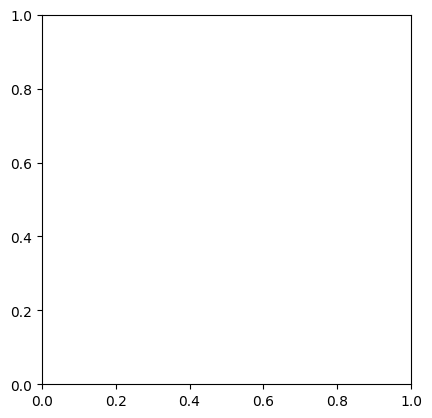

In [145]:
mask = np.argmax(z, axis=-1)
mask *= 127 
multi_slice_viewer(mask)

In [146]:
import numpy as np
import matplotlib.pyplot as plt

def display_3d_image(image):
    """
    Display a 3D image (height, width, volume slice) in three different views.
    
    Args:
    image (numpy.ndarray): 3D numpy array with shape (height, width, depth)
    """
    if len(image.shape) != 3:
        raise ValueError("Input must be a 3D numpy array")
    
    height, width, depth = image.shape
    
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Sagittal view (YZ plane)
    sagittal_slice = image[height//2, :, :]
    ax1.imshow(sagittal_slice.T, cmap='gray', aspect='auto')
    ax1.set_title('Sagittal View')
    ax1.set_xlabel('Width')
    ax1.set_ylabel('Depth')
    
    # Coronal view (XZ plane)
    coronal_slice = image[:, width//2, :]
    ax2.imshow(coronal_slice.T, cmap='gray', aspect='auto')
    ax2.set_title('Coronal View')
    ax2.set_xlabel('Height')
    ax2.set_ylabel('Depth')
    
    # Axial view (XY plane)
    axial_slice = image[:, :, depth//2]
    ax3.imshow(axial_slice, cmap='gray', aspect='auto')
    ax3.set_title('Axial View')
    ax3.set_xlabel('Width')
    ax3.set_ylabel('Height')
    
    plt.tight_layout()
    plt.show()

In [147]:
mask.shape
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}
z = model.predict(x / np.max(x), verbose=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(156, 156, 140, 4)


<Figure size 640x480 with 0 Axes>

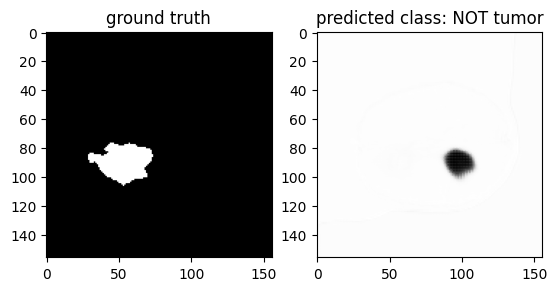

(156, 156, 140, 4)


<Figure size 640x480 with 0 Axes>

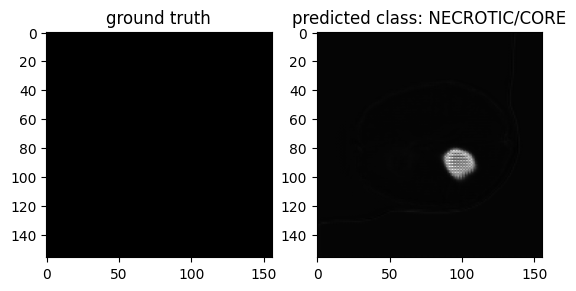

(156, 156, 140, 4)


<Figure size 640x480 with 0 Axes>

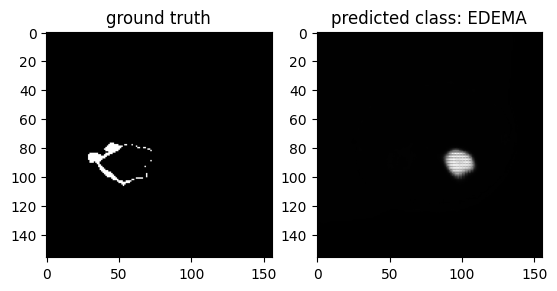

(156, 156, 140, 4)


<Figure size 640x480 with 0 Axes>

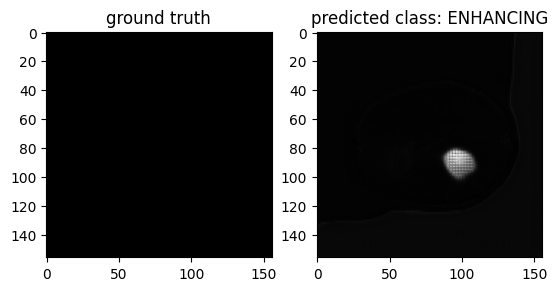

In [149]:
import cv2
def visualize_prediction(case,seg_path,i,eval_class):

  gt = nib.load(seg_path).get_fdata().astype(np.int16())

  p = case[0]
  print(p.shape)
  core = p[:, :, :, 1]
  edema = p[:, :, :, 2]
  enhancing = p[:, :, :, 3]
  # slice at
  eval_class # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'
  p = p[:, :, :, eval_class]
  gt[gt != eval_class] = 1  # use only one class for per class evaluation

  resized_gt = cv2.resize(gt[:, :, i+VolSlice_start], (156, 156))

  plt.figure()
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(resized_gt, cmap="gray")
  axarr[0].title.set_text('ground truth')
  axarr[1].imshow(p[:, :,i+VolSlice_start], cmap="gray")
  axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
  plt.show()
x = preprocess(inputpath[0])
z = model.predict(x, verbose=1)
for i in range(0, 4):
  visualize_prediction(z,outputpath[0],65,i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(156, 156, 140, 4)


<Figure size 640x480 with 0 Axes>

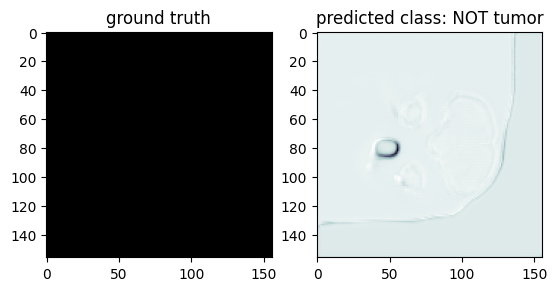

(156, 156, 140, 4)


<Figure size 640x480 with 0 Axes>

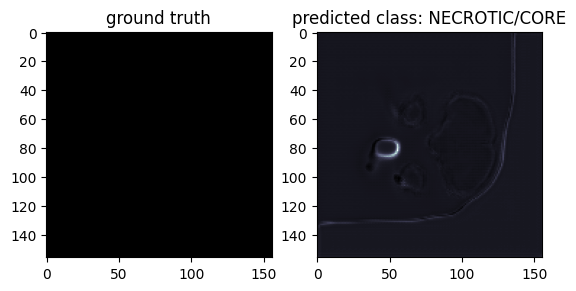

(156, 156, 140, 4)


<Figure size 640x480 with 0 Axes>

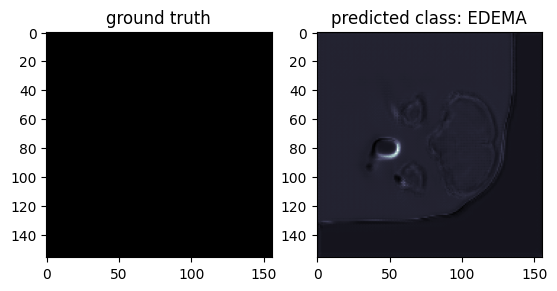

(156, 156, 140, 4)


<Figure size 640x480 with 0 Axes>

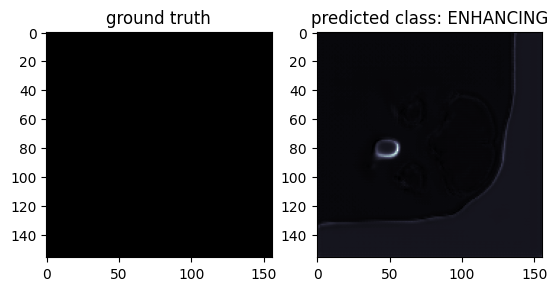

In [156]:
import cv2
def visualize_n(case,seg_path,i,eval_class):

  gt = nib.load(seg_path).get_fdata().astype(np.int16())

  p = case[0]
  print(p.shape)
  core = p[:, :, :, 1]
  edema = p[:, :, :, 2]
  enhancing = p[:, :, :, 3]
  # slice at
  eval_class # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'
  p = p[:, :, :, eval_class]
  
  resized_gt = cv2.resize(gt[:, :, i+VolSlice_start], (156, 156))
  resized_gt = tf.one_hot(resized_gt,4)[:,:,eval_class]
  plt.figure()
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(resized_gt, cmap="bone")
  axarr[0].title.set_text('ground truth')
  axarr[1].imshow(p[:, :,i+VolSlice_start], cmap="bone")
  axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
  plt.show()
x = preprocess(inputpath[0])
z = model.predict(x, verbose=1)
for i in range(0, 4):
  visualize_n(z,outputpath[0],10,i)

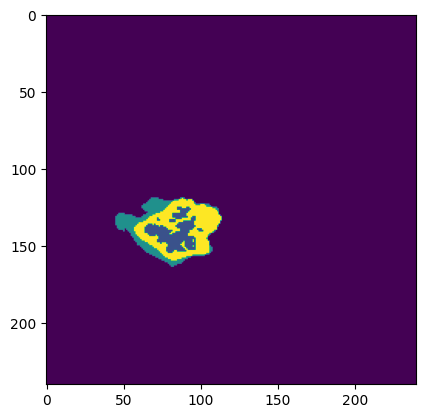

In [95]:
plt.imshow(nib.load(outputpath[0]).get_fdata()[:,:,75])

In [91]:
VolSlice_start

10

In [113]:
z.shape

(156, 156, 140, 4)